# Make ground truth for 3D U-net

Now I have several tiffs with GT and corresponding several tiffs with raw. It's good for 2D U-Net, but for 3D U-Net the input needs to be the whole stack in .n5

Take my predictions and replace parts of stack with my tiffs, save as n5. This is so annoying to have to plan things down to such details, I hope I'll have a capacity to concentrate for more than 1 minute soon...

In [1]:
import numpy as np
from elf.io import open_file
import matplotlib.pyplot as plt
import z5py
from pathlib import Path

In [2]:
raw_folder = "/g/kreshuk/buglakova/data/cryofib/F107_bin2_619-639_frames/all"
label_folder = "/g/kreshuk/buglakova/data/cryofib/corrected_labels/all"

### Open tiffs and convert to stack of images

In [3]:
with open_file(raw_folder) as f:
    raw_tiff = f["*.tiff"][:]
    print(raw_tiff.shape)

with open_file(label_folder) as f:
    labels = f["*.tiff"][:]
    # print(np.unique(labels))
    print(labels.shape)

(10, 1506, 1647)
(10, 1506, 1647)


In [4]:
def convert_to_chan(mask):
    # 0 is out of sample
    # 1 is border
    # 2 is extracellular
    # >2 are cell instances
    mask_chan = np.stack([mask == 0, mask == 1, mask == 2, mask > 2], axis=-1).astype(int)
    return mask_chan

In [5]:
labels_chan = convert_to_chan(labels)
labels_chan = np.moveaxis(labels_chan, -1, 1)

In [6]:
labels_chan.shape

(10, 4, 1506, 1647)

Plot all labeled ground truth. 0th frame obviously comes out of completely different part of stack

0


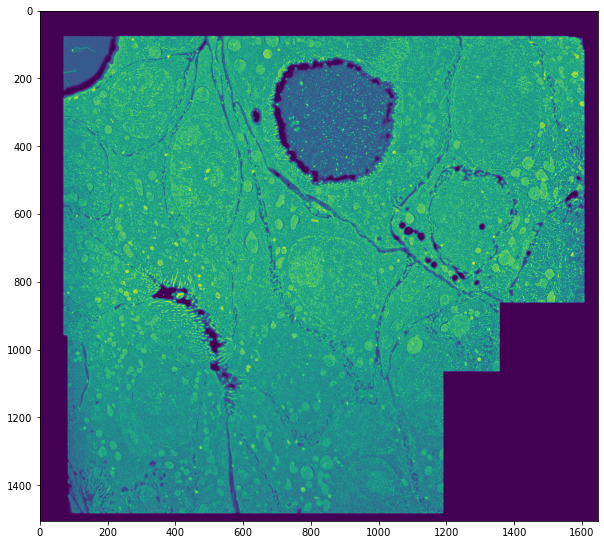

1


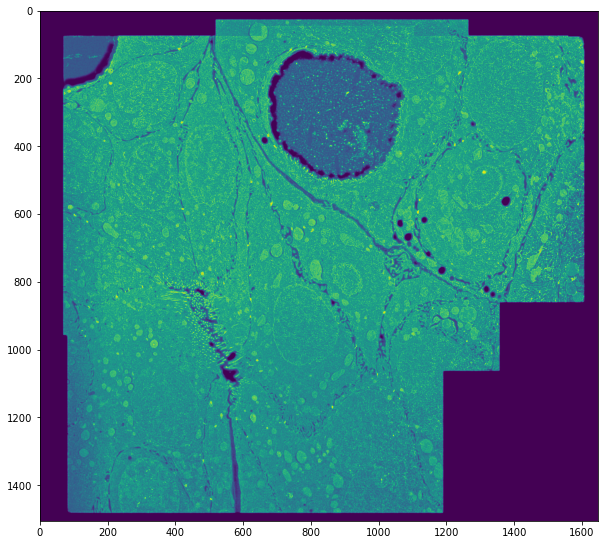

2


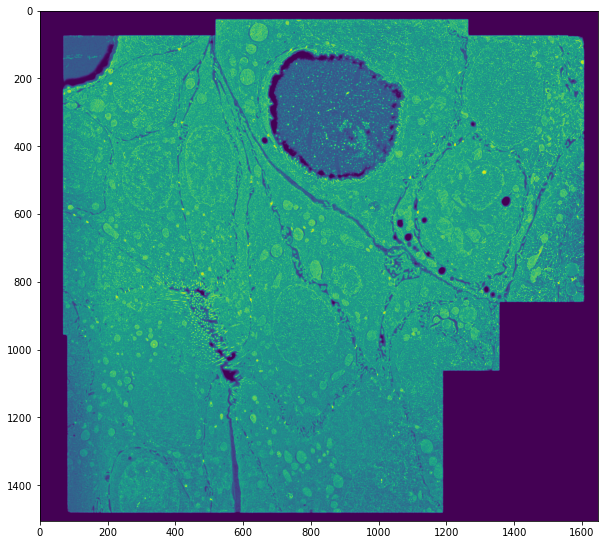

3


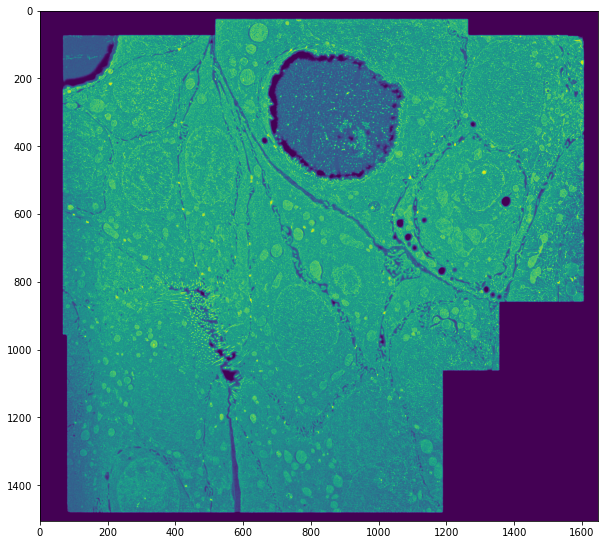

4


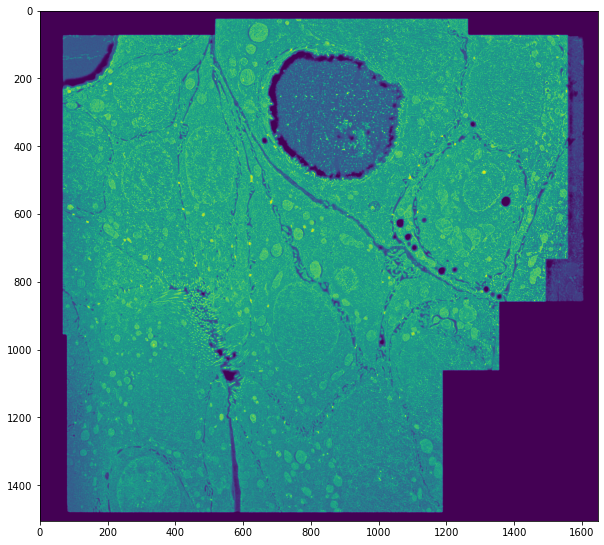

5


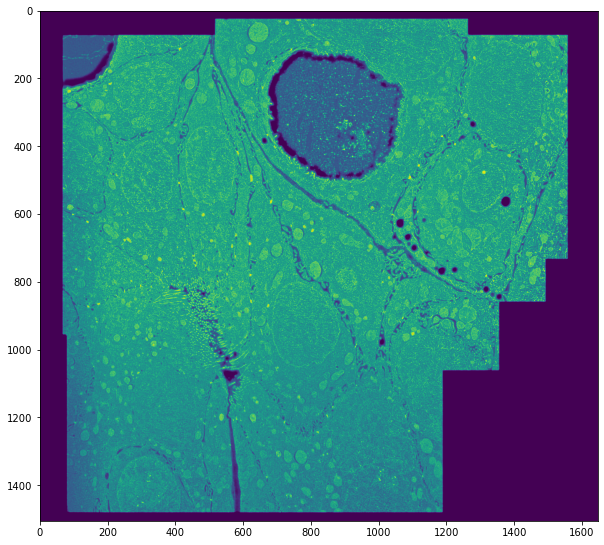

6


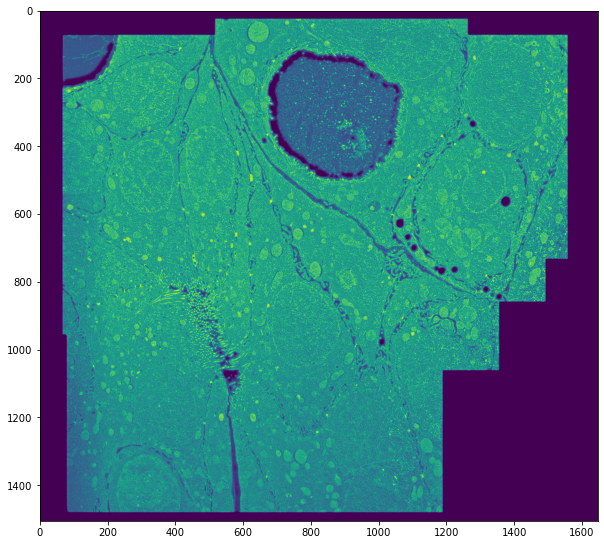

7


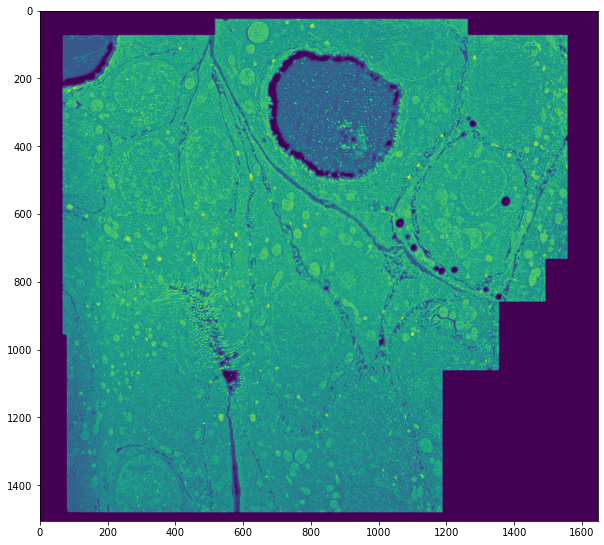

8


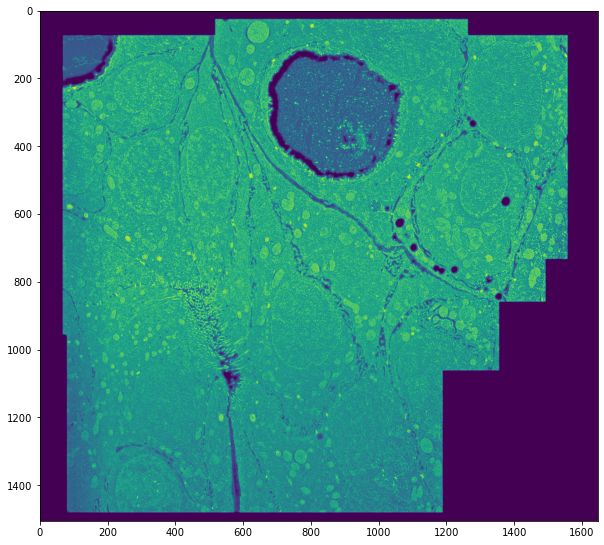

9


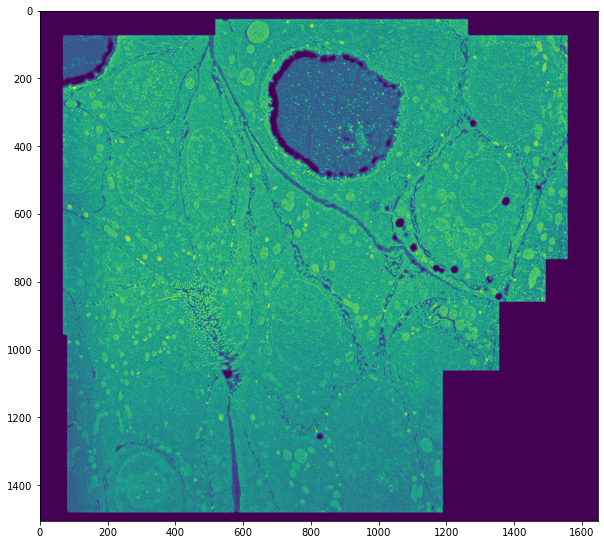

In [7]:

for i in range(10):
    plt.figure(figsize=(10, 10))
    print(i)
    plt.imshow(raw_tiff[i, :, :])
    plt.show()

Open full raw stack

In [8]:
scratch_dir = Path("/scratch/buglakova")
predictions_dir = scratch_dir / "F107_bin2_619-639_predictions"
predictions_dir.mkdir(parents=True, exist_ok=True)
n5_path = predictions_dir / "full_raw.n5"
pred_n5_path = predictions_dir / "full_predictions_ground_truth.n5"

In [24]:
print(n5_path)

/scratch/buglakova/F107_bin2_619-639_predictions/full_raw.n5


In [9]:
f = z5py.File(pred_n5_path, "r")
f_raw = z5py.File(n5_path, "r")

In [10]:
def read_raw(f: z5py.File):
    raw = f["raw"]["raw_data"]
    raw.n_threads = 8
    print("Reading raw data into memory")
    raw = raw[:]
    print("Raw data shape: ", raw.shape, type(raw))
    return raw

In [11]:
raw = read_raw(f_raw)

Reading raw data into memory
Raw data shape:  (1350, 1506, 1647) <class 'numpy.ndarray'>


In [12]:
raw.shape

(1350, 1506, 1647)

0


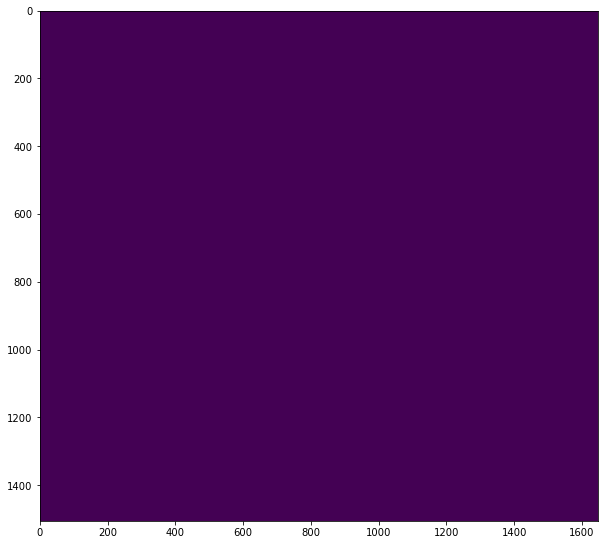

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(raw_tiff[9, :, :] - raw[626, :, :])
print(np.max(raw_tiff[9, :, :] - raw[626, :, :]))

In [14]:
for i in range(raw.shape[0]):
    if np.max(raw_tiff[0, :, :] - raw[i, :, :]) == 0:
        print(i)

566


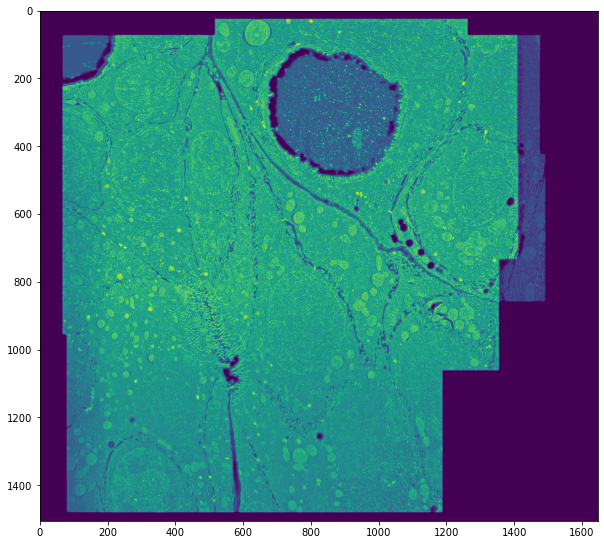

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(raw[639, :, :])

# Create volume filled with -1 and fill in parts with ground truth
Frames 1 to 9 are 618 to 626  
Frame 0 is 566

In [30]:
new_labels = np.moveaxis(np.full(raw.shape + (4,), fill_value=-1), -1, 1)

In [31]:
new_labels.shape

(1350, 4, 1506, 1647)

In [32]:
new_labels[566, ...] = labels_chan[0, ...]
new_labels[618:627, ...] = labels_chan[1:, ...]

In [33]:
new_labels[618, ...]

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

In [34]:
new_labels = np.moveaxis(new_labels, 1, 0)


In [35]:
labels_chan.shape

(10, 4, 1506, 1647)

In [36]:
new_labels.shape

(4, 1350, 1506, 1647)

Write n5 (everything together, because it might be easier for trainging?)

In [37]:
output_path = Path("/scratch/buglakova/3D_UNet_data/ground_truth_labels_CZXY.n5")

chunks = (1, 1, 512, 512)
shape = new_labels.shape
compression = "gzip"
dtype = new_labels.dtype

f = z5py.File(output_path, "a")
# g = f.create_group("predictions")

# ds_fg = g.create_dataset("foreground", shape=shape, compression="gzip",
#                             chunks=chunks, dtype="float32")
# ds_fg.n_threads = 8
# ds_bd = g.create_dataset("boundaries", shape=shape, compression="gzip",
#                     chunks=chunks, dtype="float32")
# ds_bd.n_threads = 8
# ds_extra = g.create_dataset("extracellular", shape=shape, compression="gzip",
#                     chunks=chunks, dtype="float32")
# ds_extra.n_threads = 8
# ds_bg = g.create_dataset("background", shape=shape, compression="gzip",
#                     chunks=chunks, dtype="float32")
# ds_bg.n_threads = 8

g = f.create_group("labels")
ds_labels = g.create_dataset("out_boundary_extra_fg", shape=shape, compression="gzip",
                             chunks=chunks, dtype="float32")
ds_labels.n_threads = 8
ds_labels[:] = new_labels

In [ ]:
# 0 is out of sample
# 1 is border
# 2 is extracellular
# >2 are cell instances